### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 16 февраля 2023, 08:30   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

$\textbf{MSE}$

$$-\frac{\partial}{\partial a(x_i)}L(a(x_i), y_i)=-\frac{\partial}{\partial a(x_i)}(y_i - a(x_i))^2=2(y_i - a(x_i))$$

$\textbf{Exp}$

$$-\frac{\partial}{\partial a(x_i)}L(a(x_i), y_i)=-\frac{\partial}{\partial a(x_i)}e^{-a(x_i)y_i}=e^{-a(x_i)y_i}y_i$$

$\textbf{Logit}$

$$-\frac{\partial}{\partial a(x_i)}L(a(x_i), y_i)=-\frac{\partial}{\partial a(x_i)}\log(1 + e^{-a(x_i)y_i})=-\frac{1}{1 + e^{-a(x_i)y_i}} \cdot (-e^{-a(x_i)y_i}y_i) = y_i \cdot \frac{1 + e^{-a(x_i)y_i} - 1}{1 + e^{-a(x_i)y_i}} = y_i (1 - \frac{1}{1 + e^{-a(x_i)y_i}})$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [280]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [341]:
class MyGradientBoostingClassifier:

    def __init__(self, n_estimators, loss='mse', learning_rate=0.3, colsample=None, subsample=None, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.models = []
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        class FakeModel:
            def __init__(self, return_value=0):
                self.return_value = return_value
            def fit(self, X, y):
                pass
            def predict(self, X):
                return np.full(X.shape[0], self.return_value)
        
        if init_model is None:
            self.models.append(FakeModel(y[np.random.choice(y.size)]))
        else:
            self.models.append(init_model())
        subsample_idx, self.colsample_idx = self.__sampling(self.colsample, self.subsample, X.shape[0], X.shape[1])
        X, y = X[subsample_idx][:, self.colsample_idx], y[subsample_idx]
        self.models[0].fit(X, y)
        
        for _ in range(self.n_estimators - 1):
            cur_pred = self.__predict(X)
            if self.loss == 'mse':
                antigrad_target = 2 * (y - cur_pred)
            elif self.loss == 'exp':
                antigrad_target = np.exp(-(cur_pred * y)) * y
            elif self.loss == 'logit':
                antigrad_target = y * (1 - 1 / (1 + np.exp(-(cur_pred * y))))
            new_base = base_model(*self.args, **self.kwargs).fit(X, antigrad_target)
            self.models.append(new_base)
            
    def __sampling(self, colsample, subsample, shape_0, shape_1):
        if subsample is None:
            subsample_idx = np.arange(shape_0)
        else:
            subsample_idx = np.random.choice(shape_0, size=int(shape_0 * subsample))
        
        if colsample is None:
            colsample_idx = np.arange(shape_1)
        else:
            colsample_idx = np.random.choice(shape_1, size=int(shape_1 * colsample))
        return subsample_idx, colsample_idx
        
    def __predict(self, X):
        # для обучения, так как получаем уже семплированную выборку
        base_preds = np.array([base.predict(X)*self.learning_rate for base in self.models])
        return np.round(base_preds.sum(axis=0))
    
    def predict(self, X):
        # для инференса, сэмплируем по тем признакам, по которым учились
        X = X[:, self.colsample_idx]
        base_preds = np.array([base.predict(X)*self.learning_rate for base in self.models])
        return np.round(base_preds.sum(axis=0))



In [304]:
my_clf = MyGradientBoostingClassifier(n_estimators=5)
clf = GradientBoostingClassifier()

In [305]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [306]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.9444444444444444


У меня больше, хоть и меньше итерации в 20 раз))

### Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [313]:
import matplotlib.pyplot as plt

In [314]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [315]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [316]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

In [317]:
%%time
values = np.arange(1, 50, 2)
losses = ['mse', 'exp', 'logit']
scores = {name: [] for name in losses}
for loss in losses:
    for n_estimators in values:
        clf = MyGradientBoostingClassifier(loss=loss , n_estimators=n_estimators)
        clf.fit(X_train, y_train)
        scores[loss].append(accuracy_score(y_val, clf.predict(X_val)))

Wall time: 2min 28s


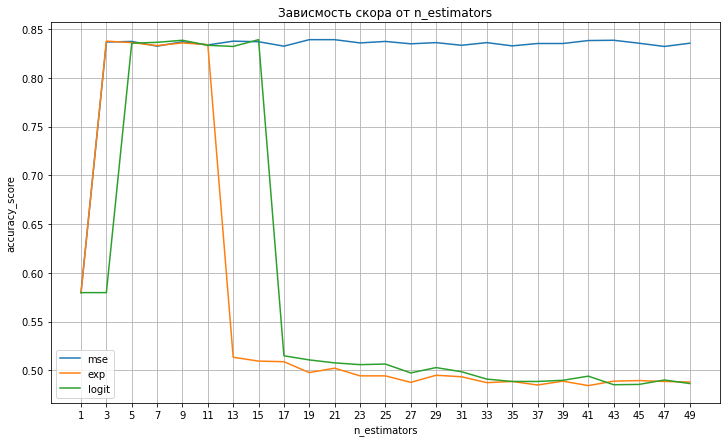

In [318]:
plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy_score')
for loss in losses:
    plt.plot(values, scores[loss], label=loss)
plt.legend();

По графикуу видно, что лоссы $\textbf{exp}$ и $\textbf{logit}$ на много сильнее подвержены переобучению, нежели $\textbf{mse}$, скор которого находится в окрестности 0.84 с увелечением итерации (наверное поэтому в sklearn оно по умолчанию). Далее буду использовать именно $\textbf{mse}$

In [319]:
%%time
values = np.arange(2, 20, 2)
lrs = np.linspace(0.01, 0.99, 5)
scores = {str(lr): [] for lr in lrs}
for lr in lrs:
    for n_estimators in values:
        clf = MyGradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr)
        clf.fit(X_train, y_train)
        scores[str(lr)].append(accuracy_score(y_val, clf.predict(X_val)))

Wall time: 27 s


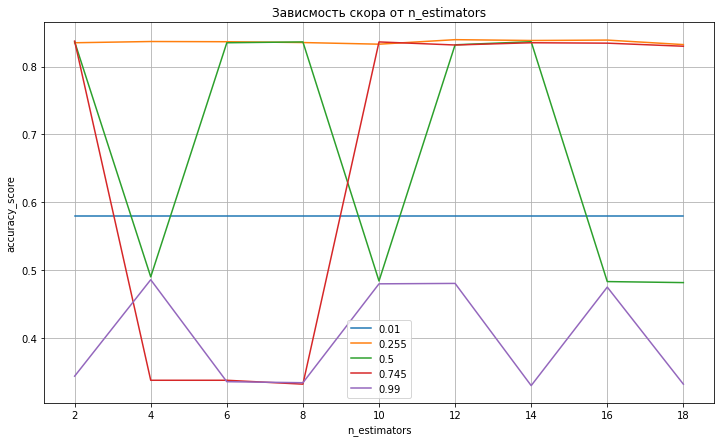

In [320]:
plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy_score')
for lr in lrs:
    plt.plot(values, scores[str(lr)], label=str(lr))
plt.legend();

Все стабильно и приличный скор у $lr = 0.255$

Проинферим на модели с найденными параметрами (n_estimators влзьмем 4)

In [336]:
%%time
clf = MyGradientBoostingClassifier(n_estimators=4, learning_rate=0.255)
clf.fit(X_train, y_train)

Wall time: 4.99 s


In [337]:
accuracy_score(y_test, clf.predict(X_test))

0.840843023255814

In [338]:
%%time
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

Wall time: 3.85 s


0.8851744186046512

Чуть хуже (на 4%) реализации sklearn

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [324]:
from sklearn.ensemble import RandomForestClassifier

Сначала сделаем случайный лес базовым алгоритмом

Wall time: 51.3 s


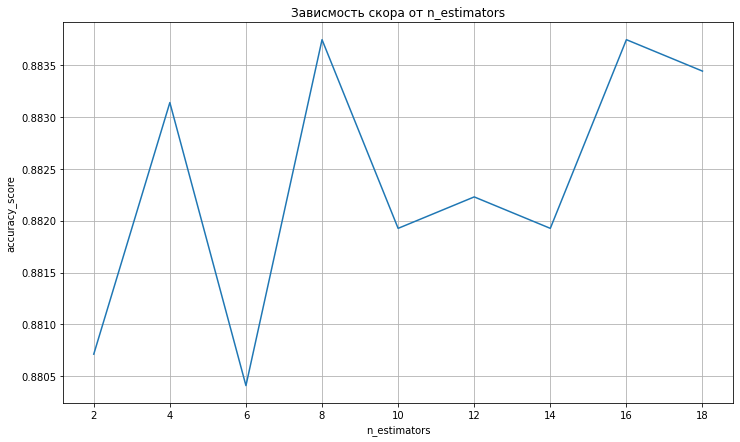

In [325]:
%%time
values = np.arange(2, 20, 2)
scores = []
for n in values:
    clf = MyGradientBoostingClassifier(n_estimators=n)
    clf.fit(X_train, y_train, base_model=RandomForestClassifier)
    scores.append(accuracy_score(y_val, clf.predict(X_val)))

plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy_score')
plt.plot(values, scores);

In [327]:
clf = MyGradientBoostingClassifier(n_estimators=8)
clf.fit(X_train, y_train, base_model=RandomForestClassifier)
accuracy_score(y_test, clf.predict(X_test))

0.8878391472868217

Скор оказался выше, хоть немного странно, ведь в бустинге мы обучаем слабенькие алгоритмы))

Теперь же будем семплировать выборку и признаки, а потом усреднять пред

Под их конфигурацию будем использовать выше найденнные параметры, а сэмплинг будет по 0.7

Wall time: 28 s


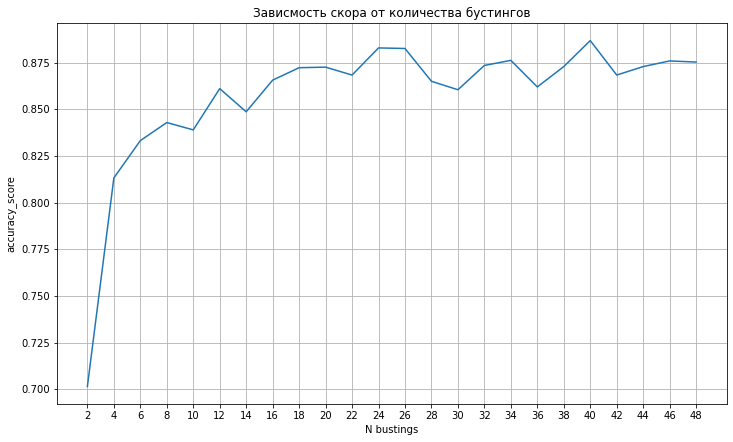

In [328]:
%%time
scores = []
values = np.arange(2, 50, 2)
for N in values:
    bustings = []
    for _ in range(N):
        clf = MyGradientBoostingClassifier(n_estimators=4, learning_rate=0.255, colsample=0.7, subsample=0.7)
        clf.fit(X_train, y_train)
        bustings.append(clf)
    y_pred = np.round(np.array([busting.predict(X_val) for busting in bustings]).mean(axis=0))
    scores.append(accuracy_score(y_val, y_pred))
    
plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от количества бустингов')
plt.xlabel('N bustings')
plt.ylabel('accuracy_score')
plt.plot(values, scores);

Кавчество растет с количеством бустингов

Объеденим обе стратегии

Wall time: 19min 6s


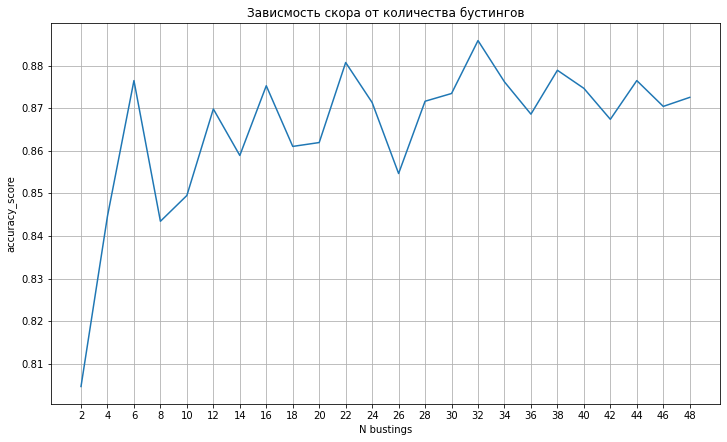

In [329]:
%%time
scores = []
values = np.arange(2, 50, 2)
for N in values:
    bustings = []
    for _ in range(N):
        clf = MyGradientBoostingClassifier(n_estimators=4, learning_rate=0.255, colsample=0.7, subsample=0.7)
        clf.fit(X_train, y_train, base_model=RandomForestClassifier)
        bustings.append(clf)
    y_pred = np.round(np.array([busting.predict(X_val) for busting in bustings]).mean(axis=0))
    scores.append(accuracy_score(y_val, y_pred))
    
plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от количества бустингов')
plt.xlabel('N bustings')
plt.ylabel('accuracy_score')
plt.plot(values, scores);

В целом никакого прироста не оказалось

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [339]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC

In [345]:
%%time
models = {'linreg': LinearRegression,
          'logreg': LogisticRegression,
          'svm': SVC,
          'decision_tree': DecisionTreeRegressor,
          'random_forest': RandomForestClassifier}
scores = {name: [] for name in models.keys()}
values = np.arange(2, 10, 2)
for model in models.keys():
    for n in values:
        clf = MyGradientBoostingClassifier(n_estimators=n)
        clf.fit(X_train, y_train, init_model=models[model])
        scores[model].append(accuracy_score(y_val, clf.predict(X_val)))


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Wall time: 4min 18s


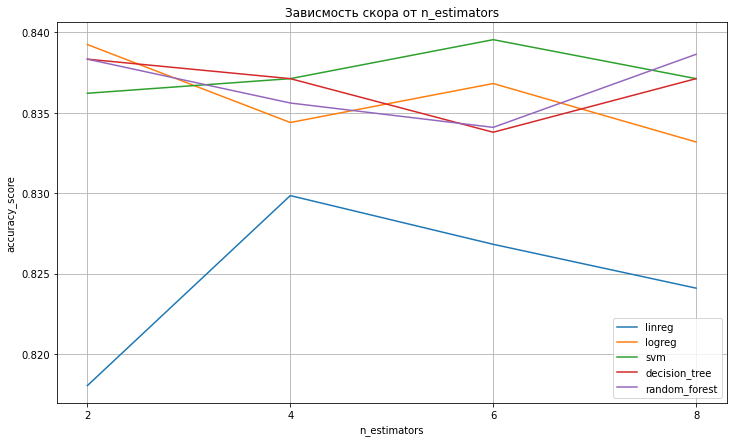

In [346]:
plt.figure(figsize=(12, 7))
plt.grid()
plt.xticks(values)
plt.title('Зависмость скора от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('accuracy_score')
for model in models.keys():
    plt.plot(values, scores[model], label=model)
plt.legend();

In [347]:
clf = MyGradientBoostingClassifier(n_estimators=6)
clf.fit(X_train, y_train, init_model=SVC)
accuracy_score(y_test, clf.predict(X_test))

0.8420542635658915

Как видно, лучше всех справился svm, но даже так прирост качества незначительный. Почему же с первоночальным константным алгоритмом работает также, то могу предположить из-за идеи уменьшения bias

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

